In [1]:
import sys, os
import pandas as pd
import numpy as np
import sklearn
from rdkit import Chem, rdBase
from rdkit.Chem import rdFMCS, Draw, PandasTools, AllChem, DataStructs, Descriptors
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import arthor
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import hex2color
import seaborn as sns
import time

print('RDKit version: ',rdBase.rdkitVersion)
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('MatplotLib version:', mpl.__version__)
print('Arthor version:', arthor.__version__)
print('Sklearn version:', sklearn.__version__)
print('Seaborn version:', sns.__version__)

RDKit version:  2021.03.3
Pandas version: 1.2.4
Numpy version: 1.20.3
MatplotLib version: 3.4.2
Arthor version: 3.4
Sklearn version: 0.24.2
Seaborn version: 0.11.1


In [2]:
import imp
import automated_series_classification
imp.reload(automated_series_classification)
from automated_series_classification import utilsDataPrep
from automated_series_classification import mainSeriesClassification
imp.reload(mainSeriesClassification)

from automated_series_classification import utilsDrawing
from automated_series_classification import UPGMAclustering
imp.reload(UPGMAclustering)


<module 'automated_series_classification.UPGMAclustering' from '/home/glandrum/miniconda3/envs/py38_automatedseries/lib/python3.8/site-packages/automated_series_classification/UPGMAclustering.py'>

Load ChEMBL database for substructure matching (constructed during data preprocessing)

In [3]:
chembldb=arthor.SubDb('./arthor/chembl_27.atdb')
Nchembl=len(chembldb.search('*'))
print(Nchembl)

1941410


Define Parameters, note that flimit corresponds to the specificity limit E(p) as described in the paper

In [4]:
flimit=2e-3
MinClusterSize=20
proj='CDK2Kinase'
filename='moldata_preprocessed.csv'
arthorpath='./arthor/'
datapath='./{0}/'.format(proj)

### UPGMA classification

Set "calcDists" to True only if the pairwise molecular distance matrix for clustering is not calculated yet (this will take a while). Set "calcScores" only if you are interested in the intra-cluster distance metric, this slows down the clustering.

In [5]:
UPGMAClassification=mainSeriesClassification.Classification(proj, datapath, arthorpath, filename, chembldb, 
                                                            flimit, MinClusterSize, clustering='UPGMA', 
                                                            calcDists=True, calcScores=False)


read 3187 molecules


In [6]:
start=time.time()
UPGMAClassification.ApplyClustering()
end=time.time()
print(f"Time elapsed during the calculation: {end-start:.1f}")   

Time elapsed during the calculation: 98.2


Benchmark against human-defined classification (seriescolumn is the column with the human series assignment to each molecule in the dataframe moldata)

In [7]:
UPGMAClassification.CalculatePerformance(seriescolumn='series assignment')

In [8]:
moldata_proj=UPGMAClassification.moldata_proj
ProjectClusters=UPGMAClassification.MCSdict
PerformanceClusters=UPGMAClassification.PerformanceClusters

### Calculate performance metrics

In [9]:
Nmol=len(moldata_proj)
Nrep=sum(moldata_proj['ClusterID'].map(lambda x: len(x)).tolist())
Nunassigned=len(moldata_proj.loc[moldata_proj['ClusterID'].map(lambda x: len(x)==0)])
frac_assigned=(Nmol-Nunassigned)/Nmol
a=Nrep/(Nmol-Nunassigned)
print('fraction of assigned molecules:',frac_assigned,', ambiguity score:',a)

fraction of assigned molecules: 0.8650768748038908 , ambiguity score: 1.1454479506710191


### Plot benchmarking between automatically identified and human defined series

rearrange performance results

In [10]:
scaflist=list(set(moldata_proj['scaffold'].tolist()))
scaflist.sort()
N_auto_series=len(PerformanceClusters['recall'])
LinkVector=PerformanceClusters['linked series']

dict_recall={LinkVector[ind,0]:np.zeros(len(scaflist)) for ind in range(N_auto_series)}
dict_prec={LinkVector[ind,0]:np.zeros(len(scaflist)) for ind in range(N_auto_series)}
for ind in range(N_auto_series):
    scafind=np.where(np.array(scaflist)==LinkVector[ind,1])
    dict_recall[LinkVector[ind,0]][scafind]=PerformanceClusters['recall'][ind]
    dict_prec[LinkVector[ind,0]][scafind]=PerformanceClusters['precision'][ind]
    
keylist=LinkVector[:,0].tolist()
keylist.sort()
dict_recall_sorted={k:dict_recall[k] for k in keylist}
dict_prec_sorted={k:dict_prec[k] for k in keylist}

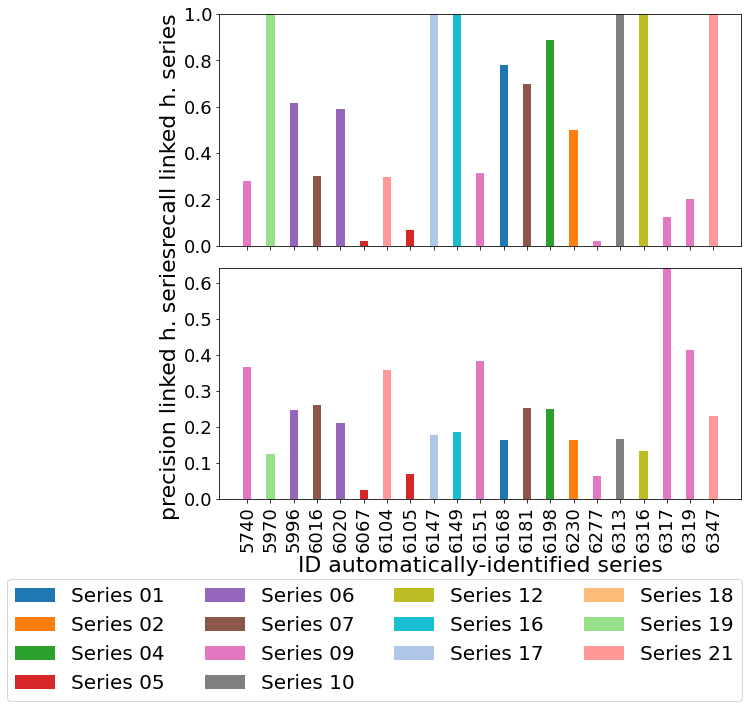

In [11]:
legend=['Series '+s[-2:] for s in scaflist]
rcParams.update({'figure.autolayout': True})
fig,ax=plt.subplots(2,1,figsize=(10,10))
fig,_=utilsDrawing.barplot_vertical(fig, ax[0],dict_recall_sorted,'recall linked h. series',[],['']*len(keylist),1.02)
fig,_=utilsDrawing.barplot_vertical(fig, ax[1],dict_prec_sorted,'precision linked h. series',legend,keylist,1.02)
ax[1].set_xlabel('ID automatically-identified series',fontsize=22)
plt.show()

### Draw MCS of automatically-identified series and linked human-defined series

In [12]:
from ipywidgets import interact,fixed,IntSlider
def renderMCS(seriesid,newscafslist,newscafsnames,linkedscafslist,linkedscafsnames):
    listid=np.where(np.array(newscafsnames)==seriesid)[0][0]
    svg_new=utilsDrawing.moltosvg(Chem.MolFromSmarts(newscafslist[listid]), molSize=(450,250))
    svg_linked=utilsDrawing.moltosvg(Chem.MolFromSmarts(linkedscafslist[listid]), molSize=(450,250))
    labels=[newscafsnames[listid],linkedscafsnames[listid]]
    svgGrid = utilsDrawing.SvgsToGrid([svg_new,svg_linked], labels=labels, svgsPerRow=2, molSize=(450,250))
    
    return(display(SVG(svgGrid)))

In [13]:
seriesdata_proj=pd.read_csv('{0}seriesdata.csv'.format(datapath))
LinkVector_sorted=np.array([[x,y] for x,y in sorted(zip(LinkVector[:,0],LinkVector[:,1]))])
linkedScafsList=[seriesdata_proj['MCSsampled'].loc[seriesdata_proj['ScafName']==x].iloc[0] for x in LinkVector_sorted[:,1]]
linkedScafsNames=[x for x in LinkVector_sorted[:,1]]
MCSlist=[ProjectClusters[int(k)][2] for k in keylist]

interact(renderMCS, seriesid=keylist, newscafslist=fixed(MCSlist),newscafsnames=fixed(keylist),linkedscafslist=fixed(linkedScafsList),linkedscafsnames=fixed(linkedScafsNames));


interactive(children=(Dropdown(description='seriesid', options=('5740', '5970', '5996', '6016', '6020', '6067'â€¦

### 10fold cross-validation by sampling 40% of all compounds

In [14]:
fraction_sample=0.4
N_sample=10
start=time.time()
UPGMAClassification.ClassificationCrossValidation(fraction_sample, N_sample)
end=time.time()
print("Time elapsed during the calculation:", end - start)   

Time elapsed during the calculation: 492.38566040992737


In [15]:
UPGMAClassification.EvaluationCrossValidation()

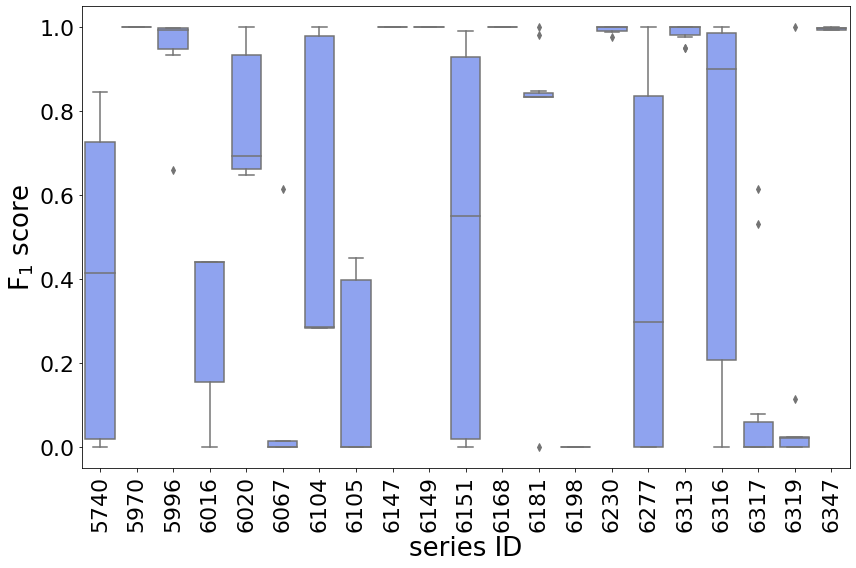

In [16]:
rcParams.update({'figure.autolayout': True})
fig,ax=plt.subplots(1,1,figsize=(12,8))
ax = sns.boxplot(x="series id", y="fscore", data=UPGMAClassification.EvalCrossval, color=[0.5,0.6,1.0],ax=ax)
ax.set_ylabel('F$_1$ score',fontsize=26)
ax.set_xlabel('series ID',fontsize=26)

plt.setp(ax.get_xticklabels(), fontsize=22, rotation='vertical')
plt.setp(ax.get_yticklabels(), fontsize=22)
plt.show()